# Phase/Orientation Mapping

This tutorial demonstrates how to achieve phase and orientation mapping via scanning electron diffraction using both pattern and vector matching.

The data was acquired from a GaAs nanowire displaying polymorphism between zinc blende and wurtzite structures.

This functionaility has been checked to run in pyxem-0.13.0 (Feb 2021). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

1. <a href='#loa'> Load & Inspect Data</a>
2. <a href='#pre'> Pre-processing</a>
3. <a href='#tem'> Template matching</a>
    1. <a href='#tema'> [Build Template Library]</a>
    2. <a href='#temb'>[Indexing]</a>
4. <a href='#vec'> Vector Matching</a>
    1. <a href='#veca'> [Build Vector Library]</a>
    2. <a href='#vecb'>[Indexing Vectors]</a>

Import pyxem and other required libraries

In [1]:
%matplotlib inline

import numpy as np
import diffpy.structure
import pyxem as pxm
import hyperspy.api as hs

accelarating_voltage = 200  # kV
camera_length = 0.2  # m
diffraction_calibration = 0.032  # px / Angstrom

<a id='loa'></a>

##  1. Loading and Inspection

Load the demo data

In [2]:
dp = hs.load('./data/02/polymorphic_nanowire.hdf5', lazy=True, reader="HSPY")
dp

C:\Users\vilja\Documents\master\hyperspy\hyperspy\io.py:628: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


<LazyElectronDiffraction2D, title: GaAs NW (110 zone), dimensions: (20, 45|144, 144)>

Set data type, scale intensity range and set calibration

In [3]:
dp.data = dp.data.astype('float64')
dp.data *= 1 / dp.data.max()

Inspect metadata

In [4]:
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 10.0
│       │       └── exposure_time = 10.0
│       ├── rocking_angle = 12.217304763960307
│       ├── rocking_frequency = 100.0
│       └── scan_rotation = 1.0
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 2.0rc0
│   │       ├── io_plugin = rsciio.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2024-01-12T14:02:45.435684+01:00
│   └── title = GaAs NW (110 zone)
└── Signal
    └── signal_type = electron_diffraction

Plot an interactive virtual image to inspect data

[########################################] | 100% Completed | 226.49 ms


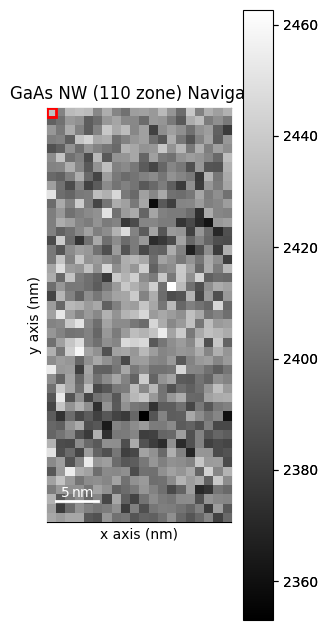

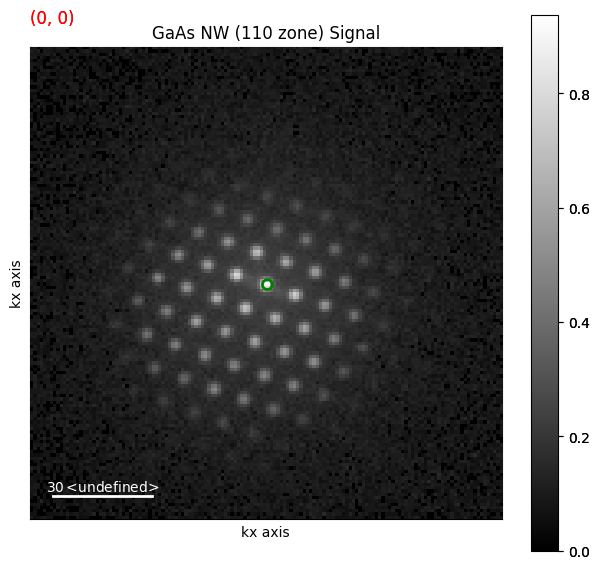

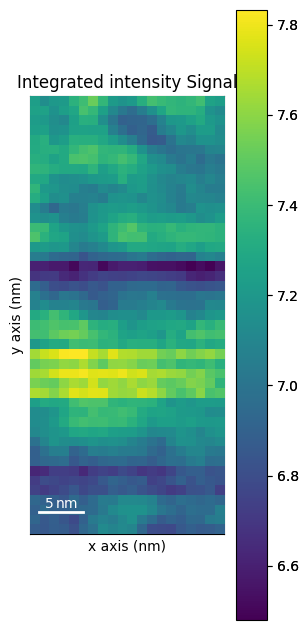

In [5]:
roi = hs.roi.CircleROI(cx=72, cy=72, r_inner=0, r=2)
dp.plot_integrated_intensity(roi=roi, cmap='viridis')

<a id='pre'></a>

##  2. Pre-processing

Apply affine transformation to correct for off axis camera geometry

In [6]:
scale_x = 0.995
scale_y = 1.031
offset_x = 0.631
offset_y = -0.351
dp.apply_affine_transformation(np.array([[scale_x, 0, offset_x],
                                         [0, scale_y, offset_y],
                                         [0, 0, 1]]))

Perform difference of gaussian background subtraction with various parameters on one selected diffraction pattern and plot to identify good parameters

In [7]:
from pyxem.utils.expt_utils import investigate_dog_background_removal_interactive

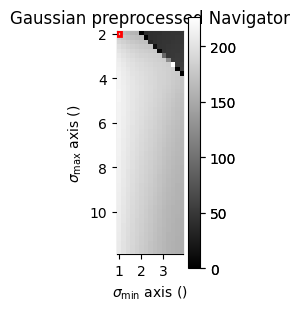

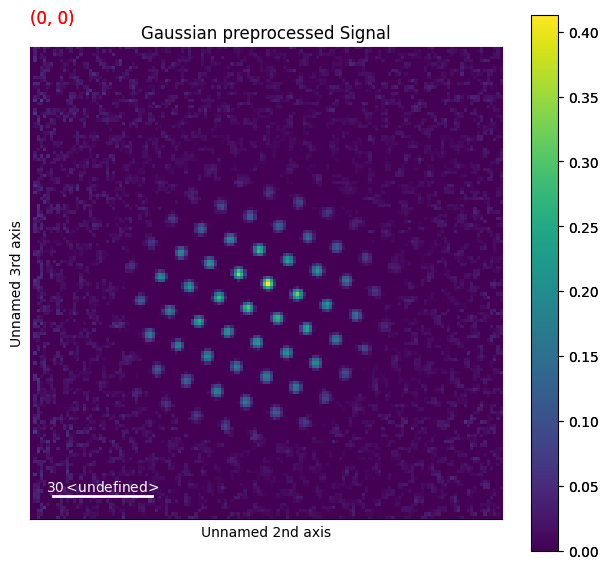

In [8]:
dp_test_area = dp.inav[0, 0]

gauss_stddev_maxs = np.arange(2, 12, 0.2) # min, max, step
gauss_stddev_mins = np.arange(1, 4, 0.2) # min, max, step

investigate_dog_background_removal_interactive(dp_test_area,
                                               gauss_stddev_maxs,
                                               gauss_stddev_mins)

Remove background using difference of gaussians method with parameters identified above

In [9]:
dp = dp.subtract_diffraction_background('difference of gaussians',
                          min_sigma=2, max_sigma=8,
                          lazy_output=False)

[########################################] | 100% Completed | 893.75 ms


Perform further adjustments to the data ranges

In [10]:
dp.data -= dp.data.min()
dp.data *= 1 / dp.data.max()

Set diffraction calibration and scan calibration

In [11]:
dp = pxm.signals.ElectronDiffraction2D(dp) #this is needed because of a bug in the code
dp.set_diffraction_calibration(diffraction_calibration)
dp.set_scan_calibration(10)

<a id='tem'></a>

##  3. Pattern Matching

Pattern matching generates a database of simulated diffraction patterns and then compares all simulated patterns against each experimental pattern to find the best match

Import generators required for simulation and indexation

In [12]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

from diffsims.generators.zap_map_generator import get_rotation_from_z_to_direction
from diffsims.generators.rotation_list_generators import get_grid_around_beam_direction

from pyxem.generators.indexation_generator import AcceleratedIndexationGenerator
from pyxem.utils.indexation_utils import results_dict_to_crystal_map

### 3.1. Define Library of Structures & Orientations

Define the crystal phases to be included in the simulated library

In [13]:
structure_zb = diffpy.structure.loadStructure('./data/02/GaAs_mp-2534_conventional_standard.cif')
structure_wz = diffpy.structure.loadStructure('./data/02/GaAs_mp-8883_conventional_standard.cif')

Create a basic rotations list.    

Construct a StructureLibrary defining crystal structures and orientations for which diffraction will be simulated 

In [14]:
rot_list_cubic = np.array([[0.0, 90.0, 225.0],])
rot_list_hex = np.array([[0.0, 90.0, 240.0],])

In [15]:
struc_lib = StructureLibrary(['ZB','WZ'],
                             [structure_zb,structure_wz],
                             [rot_list_cubic,rot_list_hex])

<a id='temb'></a>
###  3.2. Simulate Diffraction for all Structures & Orientations

Define a diffsims DiffractionGenerator with diffraction simulation parameters

In [16]:
diff_gen = DiffractionGenerator(accelerating_voltage=accelarating_voltage)

Initialize a diffsims DiffractionLibraryGenerator

In [17]:
lib_gen = DiffractionLibraryGenerator(diff_gen)

Calulate library of diffraction patterns for all phases and unique orientations

In [18]:
target_pattern_dimension_pixels = dp.axes_manager.signal_shape[0]
half_size = target_pattern_dimension_pixels // 2
reciprocal_radius = diffraction_calibration*(half_size - 1)

diff_lib = lib_gen.get_diffraction_library(struc_lib,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_size, half_size),
                                           max_excitation_error=1/10,
                                           with_direct_beam=False)

Optionally, save the library for later use.

In [19]:
diff_lib.pickle_library('./GaAs_cubic_hex.pickle')

If saved, the library can be loaded as follows

In [20]:
from diffsims.libraries.diffraction_library import load_DiffractionLibrary
diff_lib = load_DiffractionLibrary('./GaAs_cubic_hex.pickle', safety=True)

<a id='temb'></a>
###  3.3. Pattern Matching Indexation

Initialize `TemplateIndexationGenerator` with the experimental data and diffraction library and perform correlation, returning the `n_largest` matches with highest correlation.

<div class="alert alert-block alert-warning"><b>Note:</b> Try using the workflow from 11 Accelerated Orientation Mapping</div>

In [21]:
indexer = AcceleratedIndexationGenerator(dp, diff_lib)
indexation_results,phase_dict  = indexer.correlate(n_largest=3)

[########################################] | 100% Completed | 5.40 ss


Check the solutions via a plotting

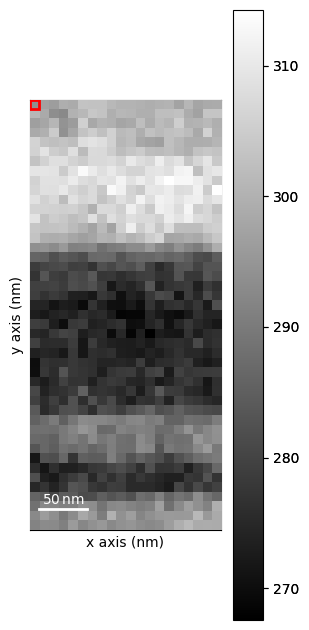

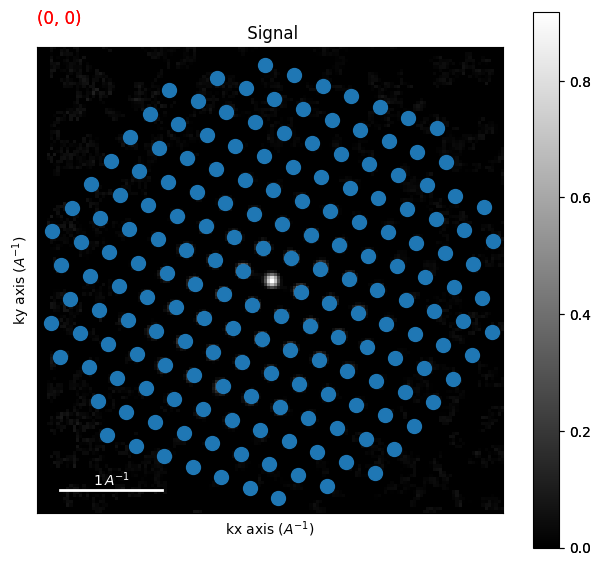

In [22]:
markers = pxm.utils.plotting_utils.generate_template_markers(dp, diff_lib, indexation_results, phase_dict, n_best = 1, scale_markers=False)
dp.plot()
dp.add_marker(markers)

Get crystallographic map from indexation results

In [23]:
crystal_map = results_dict_to_crystal_map(indexation_results, phase_key_dict=phase_dict)

crystal_map is now a CrystalMap object, which comes from orix, see their documentation for details. Below we lift their code to plot a phase map

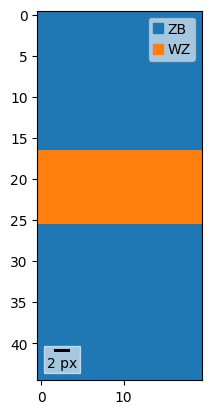

In [24]:
from matplotlib import pyplot as plt
from orix import plot

fig, ax = plt.subplots(subplot_kw=dict(projection="plot_map"))
im = ax.plot_map(crystal_map)

<a id='vec'></a>

##  4. Vector Matching

<div class="alert alert-block alert-danger"><b>Note:</b> This workflow is less well developed than the template matching one, and may well be broken</div>

Vector matching generates a database of vector pairs (magnitues and inter-vector angles) and then compares all theoretical values against each measured diffraction vector pair to find the best match

Import generators required for simulation and indexation

In [25]:
#from diffsims.generators.library_generator import VectorLibraryGenerator
#from diffsims.libraries.structure_library import StructureLibrary
#from diffsims.libraries.vector_library import load_VectorLibrary

#from pyxem.generators.indexation_generator import VectorIndexationGenerator

#from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
#from pyxem.signals.diffraction_vectors import DiffractionVectors

<a id='veca'></a>
###  4.1. Define Library of Structures

Define crystal structure for which to determine theoretical vector pairs

In [26]:
#structure_zb = diffpy.structure.loadStructure('./data/02/GaAs_mp-2534_conventional_standard.cif')
#structure_wz = diffpy.structure.loadStructure('./data/02/GaAs_mp-8883_conventional_standard.cif')

#structure_library = StructureLibrary(['ZB', 'WZ'],
#                                     [structure_zb, structure_wz],
#                                     [[], []])

Initialize VectorLibraryGenerator with structures to be considered

In [27]:
#vlib_gen = VectorLibraryGenerator(structure_library)

Determine VectorLibrary with all vectors within given reciprocal radius

In [28]:
#reciprocal_radius = diffraction_calibration*(half_size - 1)

#vec_lib = vlib_gen.get_vector_library(reciprocal_radius)

Optionally, save the library for later use

In [29]:
#vec_lib.pickle_library('./GaAs_cubic_hex_vectors.pickle')

In [30]:
#vec_lib = load_VectorLibrary('./GaAs_cubic_hex_vectors.pickle',safety=True)

### 4.2. Find Diffraction Peaks

Tune peak finding parameters interactively

In [31]:
#dp.find_peaks(interactive=False)

Perform peak finding on the data with parameters from above

In [32]:
#peaks = dp.find_peaks(method='difference_of_gaussian',
#                      min_sigma=0.005,
#                      max_sigma=5.0,
#                      sigma_ratio=2.0,
#                      threshold=0.06,
#                      overlap=0.8,
#                      interactive=False)

coaxing peaks back into a DiffractionVectors

In [33]:
#peaks = DiffractionVectors(peaks).T

`peaks` now contain the 2D positions of the diffraction spots on the detector. The vector matching method works in 3D coordinates, which are found by projecting the detector positions back onto the Ewald sphere. Because the methods that follow are slow, we constrain ourselves to looking at a smaller subset of the data

In [34]:
#peaks = peaks.inav[:2,:2]

In [35]:
#peaks.calculate_cartesian_coordinates?

In [36]:
#peaks.calculate_cartesian_coordinates(accelerating_voltage=accelarating_voltage,
#                                      camera_length=camera_length)

<a id='vecb'></a>
###  4.3. Vector Matching Indexation

Initialize `VectorIndexationGenerator` with the experimental data and vector library and perform indexation using `n_peaks_to_index` and returning the `n_best` indexation results.

<div class="alert alert-block alert-danger"><b>Alert: This code no longer works on this example, and may even be completely broken. Caution is advised.</b> </div>

In [37]:
#indexation_generator = VectorIndexationGenerator(peaks, vec_lib)

In [38]:
#indexation_results = indexation_generator.index_vectors(mag_tol=3*diffraction_calibration,
#                                                        angle_tol=4,  # degree
#                                                        index_error_tol=0.2,
#                                                        n_peaks_to_index=7,
#                                                        n_best=5,
#                                                        show_progressbar=True)

In [39]:
#indexation_results.data

Refine all crystal orientations for improved phase reliability and orientation reliability maps.

In [40]:
#refined_results = indexation_generator.refine_n_best_orientations(indexation_results,
#                                                                  accelarating_voltage=accelarating_voltage,
#                                                                  camera_length=camera_length,
#                                                                  index_error_tol=0.2,
#                                                                  vary_angles=True,
#                                                                  vary_scale=True,
#                                                                  method="leastsq")"""

Get crystallographic map from optimized indexation results.

In [41]:
#crystal_map = refined_results.get_crystallographic_map()

See the objections documentation for further details

In [42]:
#crystal_map?